# Installation, Importation et Préparation du Dataset

In [1]:
# ==============================================================================
# ÉTAPE 1 : INSTALLATIONS ET IMPORTATION DU DATASET
# ==============================================================================

!pip install -q jiwer tqdm opencv-python-headless

import torch
import pandas as pd
import os
import re
import cv2
import random
from PIL import Image
import matplotlib.pyplot as plt
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from sklearn.model_selection import train_test_split
from jiwer import cer, wer
from tqdm import tqdm

# Connexion au Drive
try:
    from google.colab import drive
    drive.mount('/content/drive')
    print("✅ Google Drive connecté avec succès !")
except:
    pass

# Importation et extraction rapide du Dataset
print("⚡ Rapatriement local du Dataset (Extraction du ZIP)...")
DOSSIER_LOCAL_IMAGES = "/content/fast_images"
os.makedirs(DOSSIER_LOCAL_IMAGES, exist_ok=True)
CHEMIN_ZIP_DRIVE = "/content/drive/MyDrive/datasetIbtissam_zip.zip"
CSV_PATH = "/content/drive/MyDrive/datasetIbtissam/labels.csv"

if os.path.exists(CHEMIN_ZIP_DRIVE):
    !cp "{CHEMIN_ZIP_DRIVE}" "/content/dataset.zip"
    !unzip -q -o "/content/dataset.zip" -d "{DOSSIER_LOCAL_IMAGES}"
    print("✅ Dataset importé et extrait localement avec succès !")
else:
    print("⚠️ ZIP non trouvé. La lecture se fera depuis le Drive (plus lent).")

# Préparation de l'échantillon de test (ex: 50 images pour une démo rapide)
df = pd.read_csv(CSV_PATH)
_, eval_df = train_test_split(df, test_size=0.1, random_state=42)
eval_df = eval_df.head(50) # On prend 50 images pour ne pas faire trop attendre le jury
print(f"📊 Données prêtes. Échantillon de validation : {len(eval_df)} images.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 43.9 MB/s eta 0:00:00
Mounted at /content/drive
✅ Google Drive connecté avec succès !
⚡ Rapatriement local du Dataset (Extraction du ZIP)...
✅ Dataset importé et extrait localement avec succès !
📊 Données prêtes. Échantillon de validation : 50 images.


# PRÉTRAITEMENT OPENCV, REGEX ET FONCTION D'ÉVALUATION

In [2]:
# ==============================================================================
# ÉTAPE 2 : PRÉTRAITEMENT OPENCV, REGEX ET FONCTION D'ÉVALUATION
# ==============================================================================

def preparer_image_pour_ia(image_path):
    img_cv = cv2.imread(image_path)
    gris = cv2.cvtColor(img_cv, cv2.COLOR_BGR2GRAY)
    flou = cv2.GaussianBlur(gris, (3, 3), 0)
    _, binaire = cv2.threshold(flou, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return img_cv, Image.fromarray(binaire).convert("RGB")

def super_nettoyeur_v3(texte_brut):
    texte = str(texte_brut)
    texte = re.sub(r'[↠≐=]+', '←', texte)
    texte = re.sub(r'<[\-\s]+', '←', texte)
    texte = re.sub(r'\bc\s*\-', '←', texte)
    texte = re.sub(r'VAR[A-Za-z\s]*_?\s*(\d+)', r'VAR_\1', texte)
    texte = re.sub(r'LIST[A-Za-z\s]*_?\s*(\d+)', r'LIST_\1', texte)
    texte = re.sub(r'IDX[A-Za-z\s]*_?\s*(\d+)', r'IDX_\1', texte)
    texte = re.sub(r'\s*←\s*', ' ← ', texte)
    texte = texte.replace("[", " [ ").replace("]", " ] ")
    texte = texte.replace("(", " ( ").replace(")", " ) ")
    texte = re.sub(r'\s*\+\s*', ' + ', texte)
    texte = re.sub(r'\s*\-\s*', ' - ', texte)
    texte = re.sub(r'\s*\/\s*', ' / ', texte)
    texte = re.sub(r'\s*\*\s*', ' * ', texte)
    texte = texte.replace("Algorithme", "algorithme")
    texte = re.sub(r'fin\s*pour', 'fin pour', texte)
    texte = re.sub(r'fin\s*si', 'fin si', texte)
    texte = re.sub(r'fin\s*tant\s*que', 'fin tant que', texte)
    texte = re.sub(r'[ \t]+', ' ', texte)
    return '\n'.join([ligne.strip() for ligne in texte.split('\n') if ligne.strip()])

device = "cuda" if torch.cuda.is_available() else "cpu"

def evaluer_modele(chemin_modele, nom_modele):
    """Fonction universelle pour tester et comparer un modèle."""
    print(f"\n🧠 Chargement et Évaluation du {nom_modele}...")
    try:
        processor = TrOCRProcessor.from_pretrained(chemin_modele)
        model = VisionEncoderDecoderModel.from_pretrained(chemin_modele).to(device)
        model.eval()
    except:
        print(f"❌ Impossible de charger {chemin_modele}")
        return

    vraies_phrases, predictions_ia = [], []
    with torch.inference_mode():
        for idx, row in tqdm(eval_df.iterrows(), total=len(eval_df), desc=f"Test {nom_modele}"):
            file_name = row['file_name'].replace("images/", "") if row['file_name'].startswith("images/") else row['file_name']

            # Recherche de l'image
            image_path = None
            for root, dirs, files in os.walk(DOSSIER_LOCAL_IMAGES):
                if file_name in files:
                    image_path = os.path.join(root, file_name)
                    break
            if not image_path:
                image_path = os.path.join("/content/drive/MyDrive/datasetIbtissam/images", file_name)

            try:
                _, image = preparer_image_pour_ia(image_path)
            except:
                continue

            pixel_values = processor(image, return_tensors="pt").pixel_values.to(device)
            generated_ids = model.generate(pixel_values, max_new_tokens=250, num_beams=3, early_stopping=True)
            texte_brut = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

            predictions_ia.append(super_nettoyeur_v3(texte_brut))
            vraies_phrases.append(super_nettoyeur_v3(row['text']))

    score_cer = cer(vraies_phrases, predictions_ia)
    score_wer = wer(vraies_phrases, predictions_ia)

    print("\n" + "="*40)
    print(f"🏆 RÉSULTATS : {nom_modele}")
    print(f"✅ Précision (1 - CER) : {max(0, (1 - score_cer) * 100):.2f} %")
    print(f"✅ Précision (1 - WER) : {max(0, (1 - score_wer) * 100):.2f} %")
    print("="*40)

print("✅ Utilitaires et Moteur d'évaluation prêts.")

✅ Utilitaires et Moteur d'évaluation prêts.


# Évaluation du Modèle V1

In [ ]:
# ==============================================================================

# ==============================================================================

!pip install -q jiwer tqdm

import torch
import pandas as pd
import os
import re
from PIL import Image
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from sklearn.model_selection import train_test_split
from jiwer import cer, wer
from tqdm import tqdm
from google.colab import drive
drive.mount('/content/drive')

# --- 1. L'ACCÉLÉRATEUR ABSOLU : COPIE DU ZIP ---
print("⚡ 1. Rapatriement local ultra-rapide via ZIP...")

DOSSIER_LOCAL_IMAGES = "/content/fast_images"
os.makedirs(DOSSIER_LOCAL_IMAGES, exist_ok=True)

CHEMIN_ZIP_DRIVE = "/content/drive/MyDrive/datasetIbtissam_zip.zip"

if os.path.exists(CHEMIN_ZIP_DRIVE):
    print("📦 ZIP trouvé ! Copie et extraction en cours...")
    !cp "{CHEMIN_ZIP_DRIVE}" "/content/dataset.zip"
    !unzip -q -o "/content/dataset.zip" -d "{DOSSIER_LOCAL_IMAGES}"
    print("✅ Images extraites localement avec succès !")
else:
    print("⚠️ Attention : Fichier ZIP non trouvé. On va lire directement sur le Drive (plus lent).")

# --- 2. CONFIGURATION (👉 C'EST ICI QU'ON PASSE SUR LA V4) ---
# On pointe maintenant vers le dossier de la V4 !
DOSSIER_MODELE = "/content/drive/MyDrive/datasetIbtissam/mon_modele_final_v4"
CSV_PATH = "/content/drive/MyDrive/datasetIbtissam/labels.csv"

def super_nettoyeur(texte_brut):
    texte = str(texte_brut)
    texte = re.sub(r'[↠≐=]+', '←', texte)
    texte = re.sub(r'<[\-\s]+', '←', texte)
    texte = re.sub(r'\bc\s*\-', '←', texte)
    texte = re.sub(r'VAR[A-Za-z\s]*_?\s*(\d+)', r'VAR_\1', texte)
    texte = re.sub(r'LIST[A-Za-z\s]*_?\s*(\d+)', r'LIST_\1', texte)
    texte = re.sub(r'IDX[A-Za-z\s]*_?\s*(\d+)', r'IDX_\1', texte)
    texte = re.sub(r'\s*←\s*', ' ← ', texte)
    texte = texte.replace("[", " [ ").replace("]", " ] ")
    texte = texte.replace("(", " ( ").replace(")", " ) ")
    texte = re.sub(r'\s*\+\s*', ' + ', texte)
    texte = re.sub(r'\s*\-\s*', ' - ', texte)
    texte = re.sub(r'\s*\/\s*', ' / ', texte)
    texte = re.sub(r'\s*\*\s*', ' * ', texte)
    texte = texte.replace("Algorithme", "algorithme")
    texte = re.sub(r'fin\s*pour', 'fin pour', texte)
    texte = re.sub(r'fin\s*si', 'fin si', texte)
    texte = re.sub(r'fin\s*tant\s*que', 'fin tant que', texte)
    texte = re.sub(r'[ \t]+', ' ', texte)
    return '\n'.join([ligne.strip() for ligne in texte.split('\n') if ligne.strip()])

# --- 3. PRÉPARATION ---
print("📊 2. Préparation des données de validation...")
df = pd.read_csv(CSV_PATH)
_, eval_df = train_test_split(df, test_size=0.1, random_state=42)

# Échantillon de 100 images pour être comparable à l'évaluation de la V3
eval_df = eval_df.head(100)
print(f"⏱️ Mode 'Pulse Check' activé : Évaluation réduite à {len(eval_df)} images.")

print("🧠 3. Chargement de la V4...")
device = "cuda" if torch.cuda.is_available() else "cpu"
processor = TrOCRProcessor.from_pretrained(DOSSIER_MODELE)
model = VisionEncoderDecoderModel.from_pretrained(DOSSIER_MODELE)
model.to(device)
model.eval()

# --- 4. ÉVALUATION ---
print(f"🚀 4. Début de l'évaluation sur {len(eval_df)} images...")
vraies_phrases = []
predictions_ia = []

with torch.inference_mode():
    for idx, row in tqdm(eval_df.iterrows(), total=len(eval_df)):
        file_name = row['file_name'].replace("images/", "") if row['file_name'].startswith("images/") else row['file_name']

        # Recherche locale
        image_path = None
        for root, dirs, files in os.walk(DOSSIER_LOCAL_IMAGES):
            if file_name in files:
                image_path = os.path.join(root, file_name)
                break

        if not image_path:
            image_path = os.path.join("/content/drive/MyDrive/datasetIbtissam/images", file_name)

        try:
            image = Image.open(image_path).convert("RGB")
        except:
            continue

        pixel_values = processor(image, return_tensors="pt").pixel_values.to(device)
        generated_ids = model.generate(pixel_values, max_new_tokens=250, num_beams=3, early_stopping=True)
        texte_brut = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

        texte_propre = super_nettoyeur(texte_brut)
        vrai_texte = super_nettoyeur(row['text'])

        vraies_phrases.append(vrai_texte)
        predictions_ia.append(texte_propre)

# --- 5. RÉSULTATS ---
score_cer = cer(vraies_phrases, predictions_ia)
score_wer = wer(vraies_phrases, predictions_ia)

print("\n" + "="*50)
print("🏆 RÉSULTATS OFFICIELS DE PERFORMANCE (V4)")
print("="*50)
precision_caractere = max(0, (1 - score_cer) * 100)
precision_mot = max(0, (1 - score_wer) * 100)

print(f"✅ Précision par Caractère (1 - CER) : {precision_caractere:.2f} %")
print(f"✅ Précision par Mot       (1 - WER) : {precision_mot:.2f} %")
print("="*50)

Mounted at /content/drive
⚡ 1. Rapatriement local ultra-rapide via ZIP...
📦 ZIP trouvé ! Copie et extraction en cours...
✅ Images extraites localement avec succès !
📊 2. Préparation des données de validation...
⏱️ Mode 'Pulse Check' activé : Évaluation réduite à 100 images.
🧠 3. Chargement de la V4...


Loading weights:   0%|          | 0/480 [00:00<?, ?it/s]

🚀 4. Début de l'évaluation sur 100 images...


100%|██████████| 100/100 [07:03<00:00,  4.24s/it]


🏆 RÉSULTATS OFFICIELS DE PERFORMANCE (V4)
✅ Précision par Caractère (1 - CER) : 55.29 %
✅ Précision par Mot       (1 - WER) : 44.56 %


# Évaluation du Modèle V2

In [ ]:


!pip install -q jiwer tqdm

import torch
import pandas as pd
import os
import re
from PIL import Image
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from sklearn.model_selection import train_test_split
from jiwer import cer, wer
from tqdm import tqdm

# --- 1. L'ACCÉLÉRATEUR ABSOLU : COPIE DU ZIP ---
print("⚡ 1. Rapatriement local ultra-rapide via ZIP...")

DOSSIER_LOCAL_IMAGES = "/content/fast_images"
os.makedirs(DOSSIER_LOCAL_IMAGES, exist_ok=True)

CHEMIN_ZIP_DRIVE = "/content/drive/MyDrive/datasetIbtissam_zip.zip"

if os.path.exists(CHEMIN_ZIP_DRIVE):
    print("📦 ZIP trouvé ! Copie et extraction en cours...")
    !cp "{CHEMIN_ZIP_DRIVE}" "/content/dataset.zip"
    !unzip -q -o "/content/dataset.zip" -d "{DOSSIER_LOCAL_IMAGES}"
    print("✅ Images extraites localement avec succès !")
else:
    print("⚠️ Attention : Fichier ZIP non trouvé. On va lire directement sur le Drive (plus lent).")

# --- 2. CONFIGURATION ---
DOSSIER_MODELE = "/content/drive/MyDrive/datasetIbtissam/mon_modele_final_v3"
CSV_PATH = "/content/drive/MyDrive/datasetIbtissam/labels.csv"

def super_nettoyeur(texte_brut):
    texte = str(texte_brut)
    texte = re.sub(r'[↠≐=]+', '←', texte)
    texte = re.sub(r'<[\-\s]+', '←', texte)
    texte = re.sub(r'\bc\s*\-', '←', texte)
    texte = re.sub(r'VAR[A-Za-z\s]*_?\s*(\d+)', r'VAR_\1', texte)
    texte = re.sub(r'LIST[A-Za-z\s]*_?\s*(\d+)', r'LIST_\1', texte)
    texte = re.sub(r'IDX[A-Za-z\s]*_?\s*(\d+)', r'IDX_\1', texte)
    texte = re.sub(r'\s*←\s*', ' ← ', texte)
    texte = texte.replace("[", " [ ").replace("]", " ] ")
    texte = texte.replace("(", " ( ").replace(")", " ) ")
    texte = re.sub(r'\s*\+\s*', ' + ', texte)
    texte = re.sub(r'\s*\-\s*', ' - ', texte)
    texte = re.sub(r'\s*\/\s*', ' / ', texte)
    texte = re.sub(r'\s*\*\s*', ' * ', texte)
    texte = texte.replace("Algorithme", "algorithme")
    texte = re.sub(r'fin\s*pour', 'fin pour', texte)
    texte = re.sub(r'fin\s*si', 'fin si', texte)
    texte = re.sub(r'fin\s*tant\s*que', 'fin tant que', texte)
    texte = re.sub(r'[ \t]+', ' ', texte)
    return '\n'.join([ligne.strip() for ligne in texte.split('\n') if ligne.strip()])

# --- 3. PRÉPARATION (LE MODE RAPIDE) ---
print("📊 2. Préparation des données de validation...")
df = pd.read_csv(CSV_PATH)
_, eval_df = train_test_split(df, test_size=0.1, random_state=42)

# 👉 L'ASTUCE EST ICI : On ne garde que les 100 premières images (Environ 9 minutes)
eval_df = eval_df.head(100)
print(f"⏱️ Mode 'Pulse Check' activé : Évaluation réduite à {len(eval_df)} images.")

print("🧠 3. Chargement de l'Intelligence Artificielle...")
device = "cuda" if torch.cuda.is_available() else "cpu"
processor = TrOCRProcessor.from_pretrained(DOSSIER_MODELE)
model = VisionEncoderDecoderModel.from_pretrained(DOSSIER_MODELE)
model.to(device)
model.eval()

# --- 4. ÉVALUATION ---
print(f"🚀 4. Début de l'évaluation sur {len(eval_df)} images...")
vraies_phrases = []
predictions_ia = []

with torch.inference_mode():
    for idx, row in tqdm(eval_df.iterrows(), total=len(eval_df)):
        file_name = row['file_name'].replace("images/", "") if row['file_name'].startswith("images/") else row['file_name']

        # 🕵️‍♂️ Recherche dans le dossier local
        image_path = None
        for root, dirs, files in os.walk(DOSSIER_LOCAL_IMAGES):
            if file_name in files:
                image_path = os.path.join(root, file_name)
                break

        if not image_path:
            image_path = os.path.join("/content/drive/MyDrive/datasetIbtissam/images", file_name)

        try:
            image = Image.open(image_path).convert("RGB")
        except:
            continue

        pixel_values = processor(image, return_tensors="pt").pixel_values.to(device)
        generated_ids = model.generate(pixel_values, max_new_tokens=250, num_beams=3, early_stopping=True)
        texte_brut = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

        texte_propre = super_nettoyeur(texte_brut)
        vrai_texte = super_nettoyeur(row['text'])

        vraies_phrases.append(vrai_texte)
        predictions_ia.append(texte_propre)

# --- 5. RÉSULTATS ---
score_cer = cer(vraies_phrases, predictions_ia)
score_wer = wer(vraies_phrases, predictions_ia)

print("\n" + "="*50)
print("🏆 RÉSULTATS OFFICIELS DE PERFORMANCE (V3 - Échantillon 100 img)")
print("="*50)
precision_caractere = max(0, (1 - score_cer) * 100)
precision_mot = max(0, (1 - score_wer) * 100)

print(f"✅ Précision par Caractère (1 - CER) : {precision_caractere:.2f} %")
print(f"✅ Précision par Mot       (1 - WER) : {precision_mot:.2f} %")
print("="*50)

⚡ 1. Rapatriement local ultra-rapide via ZIP...
📦 ZIP trouvé ! Copie et extraction en cours...
✅ Images extraites localement avec succès !
📊 2. Préparation des données de validation...
⏱️ Mode 'Pulse Check' activé : Évaluation réduite à 100 images.
🧠 3. Chargement de l'Intelligence Artificielle...


Loading weights:   0%|          | 0/480 [00:00<?, ?it/s]

🚀 4. Début de l'évaluation sur 100 images...


100%|██████████| 100/100 [08:37<00:00,  5.18s/it]


🏆 RÉSULTATS OFFICIELS DE PERFORMANCE (V3 - Échantillon 100 img)
✅ Précision par Caractère (1 - CER) : 69.50 %
✅ Précision par Mot       (1 - WER) : 59.09 %


# Transpilateur (Pseudo-code vers Python)

In [3]:
# ==============================================================================
# ÉTAPE 6 : LE TRANSPILATEUR (TRADUCTION VERS PYTHON)
# ==============================================================================

def traduire_vers_python(pseudo_code):
    lignes = pseudo_code.strip().split('\n')
    code_python = []
    indentation = 0

    for ligne in lignes:
        ligne = ligne.strip()
        if not ligne: continue

        if ligne in ["fin pour", "fin si", "fin tant que", "fin"]:
            indentation = max(0, indentation - 1)
            continue
        if ligne == "sinon":
            code_python.append("    " * max(0, indentation - 1) + "else:")
            continue

        ligne = ligne.replace(" mod ", " % ")
        prefixe = "    " * indentation

        if ligne == "algorithme":
            code_python.append("# --- Début de l'algorithme généré par l'IA ---")
        elif ligne.startswith("pour ") and " faire" in ligne:
            match = re.search(r'pour\s+(.*?)\s+de\s+(.*?)\s+a\s+(.*?)\s+faire', ligne)
            if match:
                var, debut, fin = match.groups()
                code_python.append(prefixe + f"for {var} in range({debut}, {fin} + 1):")
                indentation += 1
        elif ligne.startswith("si ") and ligne.endswith(" alors"):
            condition = ligne[3:-6].strip().replace("=", "==")
            code_python.append(prefixe + f"if {condition}:")
            indentation += 1
        elif ligne.startswith("tant que ") and ligne.endswith(" faire"):
            condition = ligne[9:-6].strip().replace("=", "==")
            code_python.append(prefixe + f"while {condition}:")
            indentation += 1
        elif "←" in ligne:
            ligne_py = ligne.replace("←", "=")
            code_python.append(prefixe + ligne_py)
        else:
            code_python.append(prefixe + ligne)

    code_python.append("\n# --- Fin de l'algorithme ---")
    return '\n'.join(code_python)

print("✅ Transpilateur Python prêt.")

✅ Transpilateur Python prêt.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🧠 1. Chargement de l'IA V3...


Loading weights:   0%|          | 0/480 [00:00<?, ?it/s]

🖼️ 2. Sélection d'une image...


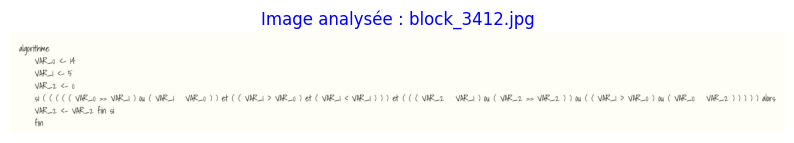

👁️ 3. Lecture par l'IA...
🧹 4. Nettoyage Regex...
🐍 5. Transpilation en Python...

📝 PSEUDO-CODE (Après IA et Nettoyage) :
algorithme
VAR_0 ← 14
VARi ( ( (
VAR_1 ← 40 ) ou ( VAR_1 ≤ VAR_0 ) ) et ( ( 86 > VAR
tant que ( ( IDX_1 ← taille (
LIST_1 ) ) ) alors ← ( ( IDX_2 ← 6 ) )
fin tant que
fin pour
si ( ( 32 mod V ) ≥ ( o > V_2 ) ) ← ( ( 100 > 100 ) mod ( 100 - VAR

💻 CODE PYTHON FINAL (Généré automatiquement) :
# --- Début de l'algorithme généré par l'IA ---
VAR_0 = 14
VARi ( ( (
VAR_1 = 40 ) ou ( VAR_1 ≤ VAR_0 ) ) et ( ( 86 > VAR
tant que ( ( IDX_1 = taille (
LIST_1 ) ) ) alors = ( ( IDX_2 = 6 ) )
si ( ( 32 % V ) ≥ ( o > V_2 ) ) = ( ( 100 > 100 ) % ( 100 - VAR

# --- Fin de l'algorithme ---


In [ ]:
# ==============================================================================
# 🌟 PIPELINE ABSOLU : IMAGE -> IA V3 -> REGEX -> PYTHON EXÉCUTABLE
# ==============================================================================






DOSSIER_MODELE_V3 = "/content/drive/MyDrive/datasetIbtissam/mon_modele_final_v3"
CSV_PATH = "/content/drive/MyDrive/datasetIbtissam/labels.csv"
DOSSIER_IMAGES = "/content/drive/MyDrive/datasetIbtissam/images"

# --- 2. LE NETTOYEUR REGEX (Pour rendre la V3 parfaite) ---
def super_nettoyeur_v3(texte_brut):
    texte = str(texte_brut)
    texte = re.sub(r'[↠≐=]+', '←', texte)
    texte = re.sub(r'<[\-\s]+', '←', texte)
    texte = re.sub(r'\bc\s*\-', '←', texte)
    texte = re.sub(r'VAR[A-Za-z\s]*_?\s*(\d+)', r'VAR_\1', texte)
    texte = re.sub(r'LIST[A-Za-z\s]*_?\s*(\d+)', r'LIST_\1', texte)
    texte = re.sub(r'IDX[A-Za-z\s]*_?\s*(\d+)', r'IDX_\1', texte)
    texte = re.sub(r'\s*←\s*', ' ← ', texte)
    texte = texte.replace("[", " [ ").replace("]", " ] ")
    texte = texte.replace("(", " ( ").replace(")", " ) ")
    texte = re.sub(r'\s*\+\s*', ' + ', texte)
    texte = re.sub(r'\s*\-\s*', ' - ', texte)
    texte = re.sub(r'\s*\/\s*', ' / ', texte)
    texte = re.sub(r'\s*\*\s*', ' * ', texte)
    texte = texte.replace("Algorithme", "algorithme")
    texte = re.sub(r'fin\s*pour', 'fin pour', texte)
    texte = re.sub(r'fin\s*si', 'fin si', texte)
    texte = re.sub(r'fin\s*tant\s*que', 'fin tant que', texte)
    texte = re.sub(r'[ \t]+', ' ', texte)
    return '\n'.join([ligne.strip() for ligne in texte.split('\n') if ligne.strip()])

# --- 3. LE TRANSPILATEUR (Pseudo-code -> Python) ---
def traduire_vers_python(pseudo_code):
    lignes = pseudo_code.strip().split('\n')
    code_python = []
    indentation = 0

    for ligne in lignes:
        ligne = ligne.strip()
        if not ligne: continue

        # --- A. Gestion des fins de blocs (on recule l'indentation) ---
        if ligne in ["fin pour", "fin si", "fin tant que", "fin"]:
            indentation = max(0, indentation - 1)
            continue

        # --- B. Gestion du Sinon ---
        if ligne == "sinon":
            code_python.append("    " * max(0, indentation - 1) + "else:")
            continue

        # --- C. Remplacements mathématiques ---
        ligne = ligne.replace(" mod ", " % ")

        prefixe = "    " * indentation

        # --- D. Traduction des structures logiques ---
        if ligne == "algorithme":
            code_python.append("# --- Début de l'algorithme généré par l'IA ---")

        elif ligne.startswith("pour ") and " faire" in ligne:
            # Cherche : pour IDX_X de A a B faire
            match = re.search(r'pour\s+(.*?)\s+de\s+(.*?)\s+a\s+(.*?)\s+faire', ligne)
            if match:
                var, debut, fin = match.groups()
                code_python.append(prefixe + f"for {var} in range({debut}, {fin} + 1):")
                indentation += 1
            else:
                code_python.append(prefixe + "# Erreur de lecture de la boucle : " + ligne)

        elif ligne.startswith("si ") and ligne.endswith(" alors"):
            condition = ligne[3:-6].strip()
            # En pseudo-code on utilise "=" pour comparer, en Python c'est "=="
            condition = condition.replace("=", "==")
            code_python.append(prefixe + f"if {condition}:")
            indentation += 1

        elif ligne.startswith("tant que ") and ligne.endswith(" faire"):
            condition = ligne[9:-6].strip()
            condition = condition.replace("=", "==")
            code_python.append(prefixe + f"while {condition}:")
            indentation += 1

        elif "←" in ligne:
            # Traduction de l'affectation
            ligne_py = ligne.replace("←", "=")
            code_python.append(prefixe + ligne_py)

        else:
            code_python.append(prefixe + ligne)

    code_python.append("\n# --- Fin de l'algorithme ---")
    return '\n'.join(code_python)

# --- 4. EXÉCUTION DU PIPELINE ---
print("🧠 1. Chargement de l'IA V3...")
device = "cuda" if torch.cuda.is_available() else "cpu"
processor = TrOCRProcessor.from_pretrained(DOSSIER_MODELE_V3)
model = VisionEncoderDecoderModel.from_pretrained(DOSSIER_MODELE_V3).to(device)

print("🖼️ 2. Sélection d'une image...")
df = pd.read_csv(CSV_PATH)
row = df.sample(1).iloc[0] # Prendre une image au hasard
file_name = row['file_name'].replace("images/", "") if row['file_name'].startswith("images/") else row['file_name']

image_path = os.path.join(DOSSIER_IMAGES, file_name)
if not os.path.exists(image_path):
    image_path = os.path.join("/content/drive/MyDrive/datasetIbtissam", file_name)

image = Image.open(image_path).convert("RGB")
plt.figure(figsize=(10, 4))
plt.imshow(image)
plt.axis('off')
plt.title(f"Image analysée : {file_name}", color="blue")
plt.show()

print("👁️ 3. Lecture par l'IA...")
pixel_values = processor(image, return_tensors="pt").pixel_values.to(device)
generated_ids = model.generate(pixel_values, max_new_tokens=250, num_beams=5, early_stopping=True)
texte_brut = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
texte_brut_lisible = texte_brut.replace(" VAR_", "\nVAR_").replace(" LIST_", "\nLIST_").replace(" pour ", "\npour ").replace(" si ", "\nsi ").replace(" sinon ", "\nsinon\n").replace(" fin ", "\nfin ")

print("🧹 4. Nettoyage Regex...")
pseudo_code_propre = super_nettoyeur_v3(texte_brut_lisible)

print("🐍 5. Transpilation en Python...")
code_python_final = traduire_vers_python(pseudo_code_propre)

# --- 5. AFFICHAGE DES RÉSULTATS ---
print("\n" + "="*50)
print("📝 PSEUDO-CODE (Après IA et Nettoyage) :")
print("="*50)
print(pseudo_code_propre)

print("\n" + "="*50)
print("💻 CODE PYTHON FINAL (Généré automatiquement) :")
print("="*50)
print(code_python_final)
print("="*50)